# Install

In [ ]:
!pip install streamfuels

DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/streamfuels-0.1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/tqdm-4.65.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
Cloning into 'StreamFuels'...
remote: Enumerating objects: 145, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 145 (delta 77), reused 94 (delta 33), pack-reused 0 (from 0)
Receiving objects: 100% (145/145), 99.58 KiB | 3.56 MiB/s, done.
Resolving deltas: 100% (77/77), done.
running install
/usr/local/lib/python3.11/dist-packages/setuptools/_distutils/cmd.p

# Import DatasetLoader from StreamFuels

In [ ]:
from streamfuels.datasets import DatasetLoader
loader = DatasetLoader()

# Forecasting

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def pocid(y_true, y_pred):
  n = len(y_true)
  D = [1 if (y_pred.iloc[i] - y_pred.iloc[i-1]) * (y_true.iloc[i] - y_true.iloc[i-1]) > 0 else 0 for i in range(1, n)]
  POCID = 100 * np.sum(D) / (n-1)
  return POCID

def smape(y_pred, y_true):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    denominator[denominator == 0] = 1e-8
    return 100 * np.mean(np.abs(y_pred - y_true) / denominator)

# Load the Monthly Fuel Sales by State dataset

In [ ]:
result, flag = loader.monthly_sales_state()
df, metadata = loader.read_tsf(path_tsf=result)

dataset downloaded at: ./monthly_fuel_sales_by_state.tsf


# Train and test ARIMA and ETS forecasting models for all series of the dataset, considering the suggested horizon in metadata (i.e., $h=12$ for monthly datasets and $h=5$ for yearly datasets)

In [ ]:
h = metadata['horizon']
df['ARIMA POCID'] = None
df['ARIMA SMAPE'] = None
df['ETS POCID'] = None
df['ETS SMAPE'] = None

for i in range(len(df)):
  series = pd.Series(df.iloc[i]['series_value'])
  series_train = series[:-h]
  series_test = series[-h:]
  if len(series_train) > h*2 and series_train.std() > 1e-3: # ignore too small series (e.g., 9 observations)
    # ARIMA
    arima_model = ARIMA(series_train, order=(2, 1, 2)).fit()
    arima_forecast = arima_model.forecast(steps=h)
    arima_pocid = pocid(series_test, arima_forecast)
    arima_smape = smape(arima_forecast, series_test)
    df.at[i, 'ARIMA POCID'] = arima_pocid
    df.at[i, 'ARIMA SMAPE'] = arima_smape

  # ETS
    ets_model = ExponentialSmoothing(series_train, trend="add", seasonal="add", initialization_method="estimated", seasonal_periods=h).fit()
    ets_forecast = ets_model.forecast(steps=h)
    ets_pocid = pocid(series_test, ets_forecast)
    ets_smape = smape(ets_forecast, series_test)
    df.at[i, 'ETS POCID'] = ets_pocid
    df.at[i, 'ETS SMAPE'] = ets_smape
  else:
    df.at[i, 'ARIMA POCID'] = np.nan
    df.at[i, 'ARIMA SMAPE'] = np.nan
    df.at[i, 'ETS POCID'] = np.nan
    df.at[i, 'ETS SMAPE'] = np.nan



# Show the updated dataframe with the forecasting results

In [ ]:
df.head(5)

,series_name,start_timestamp,end_timestamp,state_code,product,operation,series_value,ARIMA POCID,ARIMA SMAPE,ETS POCID,ETS SMAPE
0,T1,1997-01-01,2025-12-01,AL,petroleum,production,"[16691.0, 17684.0, 16639.0, 19108.0, 20665.0, ...",9.090909,164.339435,27.272727,154.641735
1,T2,1997-01-01,2025-12-01,BA,petroleum,production,"[257582.0, 250455.0, 259712.0, 248491.0, 25124...",18.181818,151.229183,9.090909,151.366584
2,T3,1997-01-01,2025-12-01,CE,petroleum,production,"[69006.0, 73759.0, 76851.0, 71571.0, 68377.0, ...",9.090909,177.038163,18.181818,152.712524
3,T4,1997-01-01,2025-12-01,MA,petroleum,production,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",9.090909,192.834214,9.090909,165.313109
4,T5,1997-01-01,2025-12-01,RN,petroleum,production,"[435336.0, 429755.0, 439056.0, 432781.0, 42283...",27.272727,189.913949,0.0,190.070951


# Example of forecast

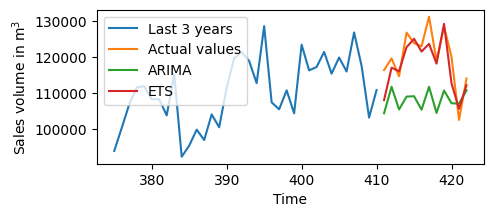

In [ ]:
# Example of Gasoline-r in Tocantins (TO) state (i=88)
# Example of Diesel in Mato Grosso do Sul (MS) state (i=42)
# Example of LPG in São Paulo (SP) state (i=34)
# Example of Kerosene-i in Minas Gerais (MG) state (i=177)

i=88
series = pd.Series(df.iloc[i]['series_value'])
series_train = series[:-h]
series_test = series[-h:]

# ARIMA
arima_model = ARIMA(series_train, order=(2, 1, 2)).fit()
arima_forecast = arima_model.forecast(steps=h)

# ETS
ets_model = ExponentialSmoothing(series_train, trend="add", seasonal="add", initialization_method="estimated", seasonal_periods=h).fit()
ets_forecast = ets_model.forecast(steps=h)


plt.figure(figsize=(5,2))
plt.plot(series_train[-36:], label='Last 3 years')
plt.plot(series_test, label='Actual values')
plt.plot(arima_forecast, label='ARIMA')
plt.plot(ets_forecast, label='ETS')

plt.xlabel('Time')
plt.ylabel(f'Sales volume in m$^3$')
plt.legend()